In [1]:
"""
Data visualization
Author: Xionghui Xu
Date: July 11, 2025
"""
import os
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
import rioxarray as rxr
from concurrent.futures import ThreadPoolExecutor
import warnings
from pathlib import Path

# Visualization

In [2]:
%matplotlib inline

import geopandas as gpd
from pylab import rcParams
import seaborn as sns
import salem
import gc
import tracemalloc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry import box
from shapely.ops import unary_union
import cmaps

## Extended Data Fig. 8c

In [3]:
# Configuration
CONFIG = {
    'resolution' : "500",
    'region' : [-180,180,-60,90],
    'data_path' : f'data/run/',
    'shp_path' : 'data/Shp/',
    'field_path' : 'data/field/',
    'fig_path' : 'fig/',
    'size': 0.0005,
    'extent': [-124.8, -66.95, 24.5, 49.4],  # xmin, xmax, ymin, ymax
    'levels': [0, 100, 150, 200, 220, 240, 300, 400, 700, 1000, 1500, 2000, 4000, 8000],
    'cmap': cmaps.cmocean_balance,
}

# Matplotlib settings
rcParams.update({
    'backend': 'ps',
    'axes.labelsize': 25,
    'grid.linewidth': 0.2,
    'font.size': 25,
    'font.family': 'Arial',
    'legend.fontsize': 18,
    'legend.frameon': False,
    'xtick.labelsize': 30,
    'xtick.direction': 'out',
    'ytick.labelsize': 30,
    'ytick.direction': 'out',
    'legend.handlelength': 1,
    'legend.handleheight': 1,
    'savefig.bbox': 'tight',
    'axes.unicode_minus': False,
    'mathtext.default': 'regular',
    'text.usetex': False,
})

# Initialize global data
shp = gpd.GeoDataFrame.from_file(os.path.join(CONFIG['shp_path'], 'US/USA_adm0.shp'))
shp_fixed = shp.copy()
shp_fixed['geometry'] = shp_fixed['geometry'].buffer(0)  # Preprocess shapefile once
df2 = pd.read_csv(os.path.join(CONFIG['data_path'], 'csv/field_DTB.csv'))  # Load CSV once

# Dataset configurations
DATASETS = [
    {
        'file': 'data/DTB/DTB_Pelletier/average_soil_and_sedimentary-deposit_thickness_remap_cm.nc',
        'name': 'Pelletier et al.',
        'use_df2': True,
    },
    {
        'file': 'data/DTB/DTB_gNATSGO/Bedrock_US_gNATSGO_90m.nc',
        'name': 'gNATSGO',
        'use_df2': False,
    },
    {
        'file': 'data/DTB/DTB_Shangguan/DTB_tmp2.nc',
        'name': 'Shangguan et al.',
        'use_df2': False,
    },
]

In [6]:
def define_colormap(levels, cmap):
    """Define custom colormap and normalization."""
    # Generate colormap
    cmap = plt.get_cmap(cmap)
    color = cmap(np.linspace(0, 1, len(levels) - 1))
    cmap_custom = colors.ListedColormap(color)
    cmap_custom.set_under(cmap(0))
    cmap_custom.set_over(color[-1])
    norm = colors.BoundaryNorm(levels, cmap_custom.N)
    return cmap_custom, norm

def load_and_process_data(file_path, shp, extent):
    """Load and process NetCDF data with region selection and shapefile masking."""
    # Load dataset and select region
    ds = xr.open_dataset(file_path).sel(lon=slice(extent[0], extent[1]), lat=slice(extent[2], extent[3]))
    data = ds['Band1']
    # Apply spatial filtering
    data = data.where((data.lon >= extent[0]) & (data.lon <= extent[1]) &
                      (data.lat >= extent[2]) & (data.lat <= extent[3]), drop=True)
    # Apply shapefile mask
    data = data.salem.roi(shape=shp)
    return data

def plot(ax, data, name, extent, df2=None, cmap=None, norm=None):
    """Plot data on a map with shapefile overlay."""
    # Mask NaN values
    data = np.ma.masked_where(np.isnan(data), data)
    data = np.flipud(data)
    # Plot data
    img = ax.imshow(data, cmap=cmap, extent=extent, norm=norm)
    
    # Clip and plot shapefile
    bbox = gpd.GeoSeries([box(*extent)], crs=shp_fixed.crs)
    clipped_shapefile = gpd.clip(shp_fixed, bbox)
    clipped_shapefile.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)
    
    for spine in ax.spines.values():
        spine.set_linewidth(0)

    # Customize axes
    ax.set_title(name, fontsize=24, fontweight='bold')
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    # Add features
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    
    # Plot scatter points if df2 is provided
    if df2 is not None:
        df3 = df2.copy().sort_values(by='lon').reset_index(drop=True)
        df3 = df3[df3['lon'] < 0]
        ax.scatter(df3['lon'], df3['lat'], marker='o', s=60, linewidths=2,
                   edgecolors="black", facecolors="#22b14c", zorder=2)
    
    return img

Memory usage before plotting Pelletier et al.:
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/figure.py:2534: size=2320 B, count=3, average=773 B
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/patches.py:720: size=2208 B, count=1, average=2208 B
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/cbook.py:188: size=1080 B, count=5, average=216 B
Mean value for Pelletier et al.: 1755.9011754146702
Memory usage before plotting gNATSGO:
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/cbook.py:733: size=633 MiB, count=2, average=317 MiB
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/numpy/ma/core.py:3046: size=79.1 MiB, count=3, average=26.4 MiB
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/path.py:339: size=20.8 MiB, count=25540, average=853 B
Mean value for gNATSGO: 146.94417797383622
Memory usage before plotting Shangguan et al.:
/

/tmp/ipykernel_3063097/1392902705.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


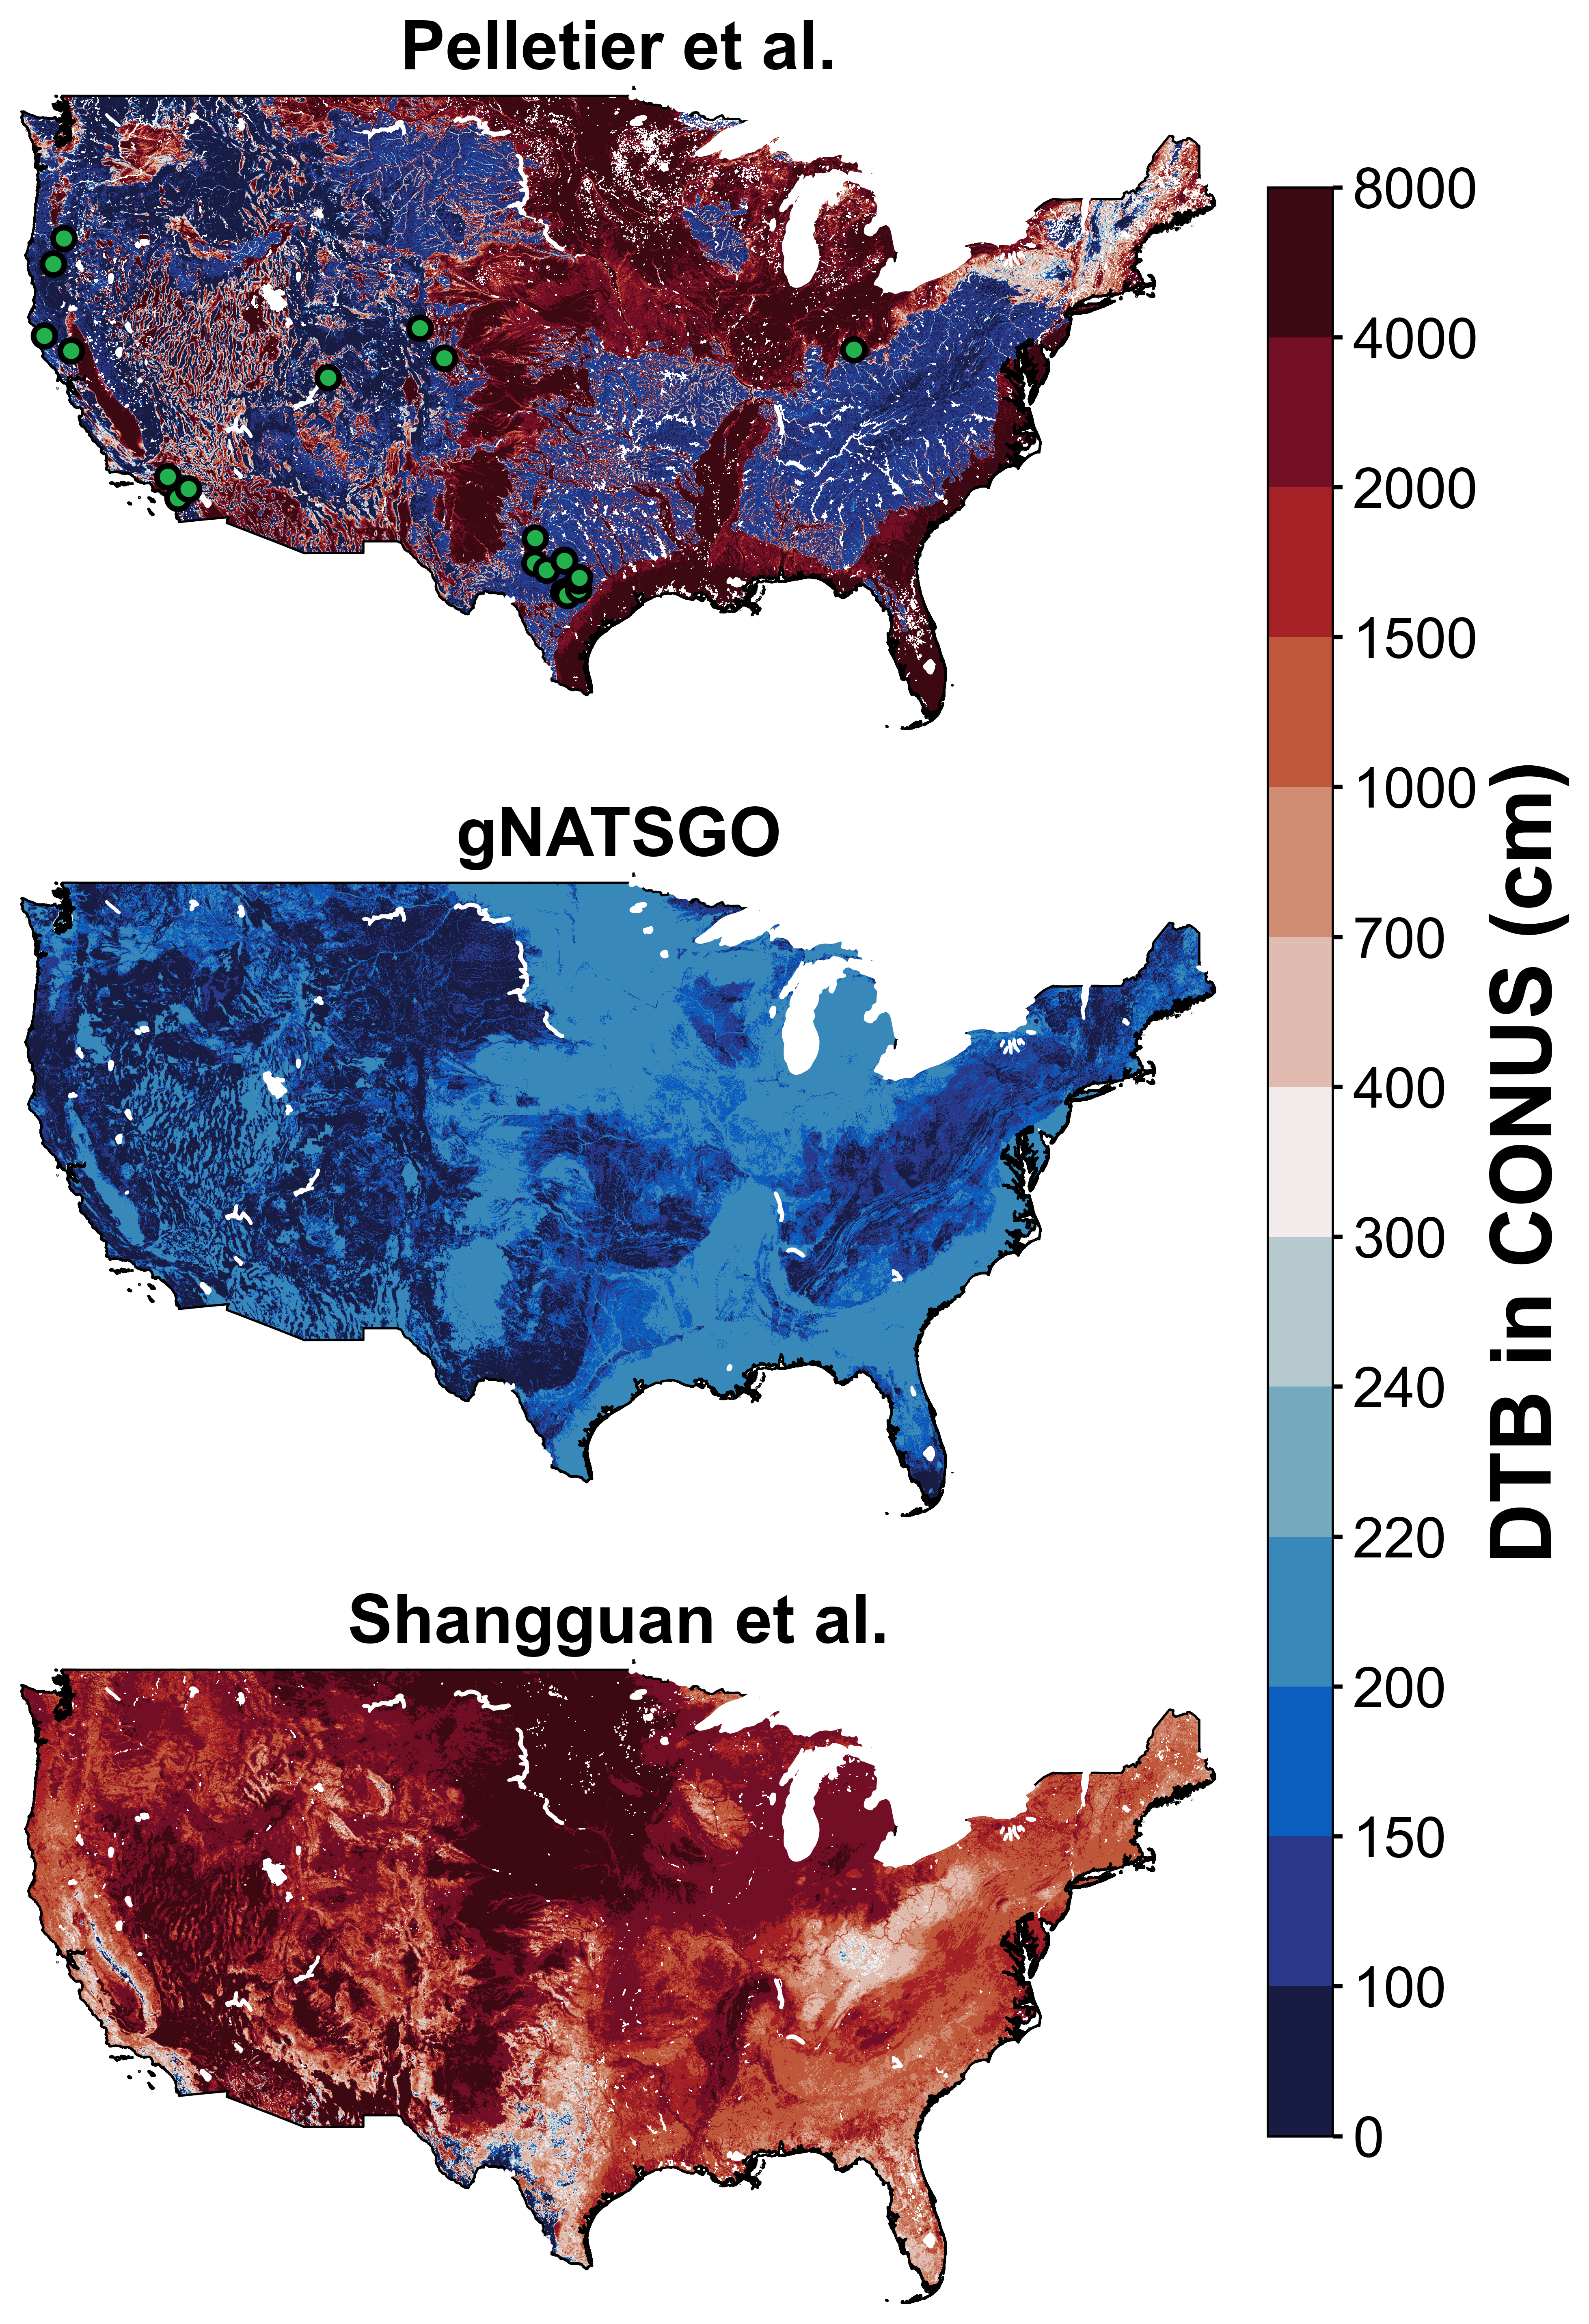

Final memory usage:
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/cbook.py:733: size=17.3 GiB, count=9, average=1970 MiB
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/numpy/ma/core.py:3046: size=2256 MiB, count=7, average=322 MiB
/home/xuxh22/anaconda3/envs/jupyter/lib/python3.10/site-packages/matplotlib/path.py:339: size=62.3 MiB, count=76636, average=853 B


In [8]:
def main():
    """Main function to plot all datasets."""
    # Start memory tracking
    tracemalloc.start()
    
    # Initialize figure
    fig = plt.figure(figsize=(8, 12), dpi=500)
    fig.subplots_adjust(left=0.05, right=0.85, bottom=0.05, top=0.95, hspace=0.1)
    gs = GridSpec(3, 1, height_ratios=[1, 1, 1])
    
    # Define colormap
    cmap, norm = define_colormap(CONFIG['levels'], CONFIG['cmap'])
    
    # Plot each dataset
    for i, dataset in enumerate(DATASETS):
        # Log memory usage
        snapshot = tracemalloc.take_snapshot()
        top_stats = snapshot.statistics('lineno')
        print(f"Memory usage before plotting {dataset['name']}:")
        for stat in top_stats[:3]:
            print(stat)
        
        # Load and process data
        data = load_and_process_data(dataset['file'], shp_fixed, CONFIG['extent'])
        print(f"Mean value for {dataset['name']}: {data.mean().values}")
        
        # Plot data
        ax = fig.add_subplot(gs[i, :], projection=ccrs.PlateCarree())
        df = df2 if dataset['use_df2'] else None
        img = plot(ax, data, dataset['name'], CONFIG['extent'], df, cmap, norm)
        
        # Clean up
        del data
        gc.collect()
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.9, 0.1, 0.04, 0.8])
    cb = fig.colorbar(img, cax=cbar_ax, ticks=CONFIG['levels'], orientation='vertical', spacing='uniform')
    cb.ax.tick_params(labelsize=20, direction='out', width=1.5)
    # for label in cb.ax.get_yticklabels():
    #     label.set_fontproperties(fm.FontProperties(weight='bold'))
    cb.set_label("DTB in CONUS (cm)", fontsize=30, fontweight='bold')
    
    # Display and save
    plt.tight_layout()
    plt.show()
    
    # Log final memory usage
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    print("Final memory usage:")
    for stat in top_stats[:3]:
        print(stat)
    
    tracemalloc.stop()

if __name__ == "__main__":
    main()